In [1]:
from fastai.vision import *
from fastai.distributed import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback


from gepcore.utils import cell_graph, convolution
from gepcore.entity import Gene, Chromosome
from gepcore.symbol import PrimitiveSet
from gepnet.model import get_gepnet, arch_config
from gepnet.utils import count_parameters
torch.backends.cudnn.benchmark = True

if torch.cuda.is_available():
  print("Great! Good to go!")
else:
  print('CUDA is not up!')

from pygraphviz import AGraph
import glob

Great! Good to go!


In [2]:
gpath = '/home/cliff/ResearchProjects/geppy_nn/mlj_experiments/4-2-train/4-2-seed-2/best/indv_0'
graph = [AGraph(g) for g in glob.glob(gpath+'/*.dot')]
_, comp_graph = cell_graph.generate_comp_graph(graph)
#print(comp_graph)

In [4]:
conf = arch_config(comp_graph=comp_graph,
                   depth_coeff=1.0,
                   width_coeff=1.0,
                   channels=16,
                   repeat_list=[2, 3, 2, 1],
                   classes=30)

net = get_gepnet(conf)
count_parameters(net)

5.035182

In [10]:
tfms = get_transforms(do_flip=False)
path = Path("/home/cliff/rs_imagery/AID")

bs = 96

data = (ImageList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=bs, num_workers=num_cpus())
        .normalize())

In [11]:
model_dir = gpath #'/home/cliff/ResearchProjects/models/random_search/'
model = Learner(data, net, metrics=[accuracy, error_rate]).load(model_dir+'/aid-model-s422')
_, acc, err = model.validate()
print('Accuracy: %.2f | Error: %.2f' %(acc.item()*100, err.item()*100))

Accuracy: 96.15 | Error: 3.85


In [6]:
model.validate(data.valid_dl)

[0.16320013, tensor(0.9656), tensor(0.0344)]

In [12]:
class CM(ClassificationInterpretation):
    "Interpretation methods for classification models."
    def __init__(self, learn:Learner, preds:Tensor, y_true:Tensor, 
                 losses:Tensor, ds_type:DatasetType=DatasetType.Valid):
        super().__init__(learn,preds,y_true,losses,ds_type)
        self.pred_class = self.preds.argmax(dim=1)


    def plot_cm(self, normalize:bool=False, cmap:Any="Blues",
                              slice_size:int=1, norm_dec:int=2, plot_txt:bool=True, return_fig:bool=None,
                              **kwargs)->Optional[plt.Figure]:
        "Plot the confusion matrix, with `title` and using `cmap`."
        # This function is mainly copied from the sklearn docs
        cm = self.confusion_matrix(slice_size=slice_size)
        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig = plt.figure(**kwargs)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        #plt.title('Confusion Matrix')
        tick_marks = np.arange(self.data.c)
        plt.xticks(tick_marks, self.data.y.classes, rotation=90)
        plt.yticks(tick_marks, self.data.y.classes, rotation=0)

        if plot_txt:
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                #print(cm[i, j]*100)
                #coeff = f'{cm[i, j]*100:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
                if cm[i, j]==0.0:
                    coeff = '-'
                if 0.0<cm[i, j]<0.2:
                    norm_dec = 1
                    coeff = f'{cm[i, j]*100:.{norm_dec}f}'
                if cm[i, j] >=0.20:
                    norm_dec = 0
                    #print(cm[i, j])
                    coeff = f'{cm[i, j]*100:.{norm_dec}f}'
                           
                plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
        
        ax = fig.gca()
        ax.set_ylim(len(self.data.y.classes)-.5,-.5)
                           
        plt.tight_layout()
        plt.ylabel('True Scene Classes')
        plt.xlabel('Predicted Scene Classes')
        plt.grid(False)
        if ifnone(return_fig, defaults.return_fig): return fig

In [13]:
cm = CM.from_learner(model)
losses,idxs = cm.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

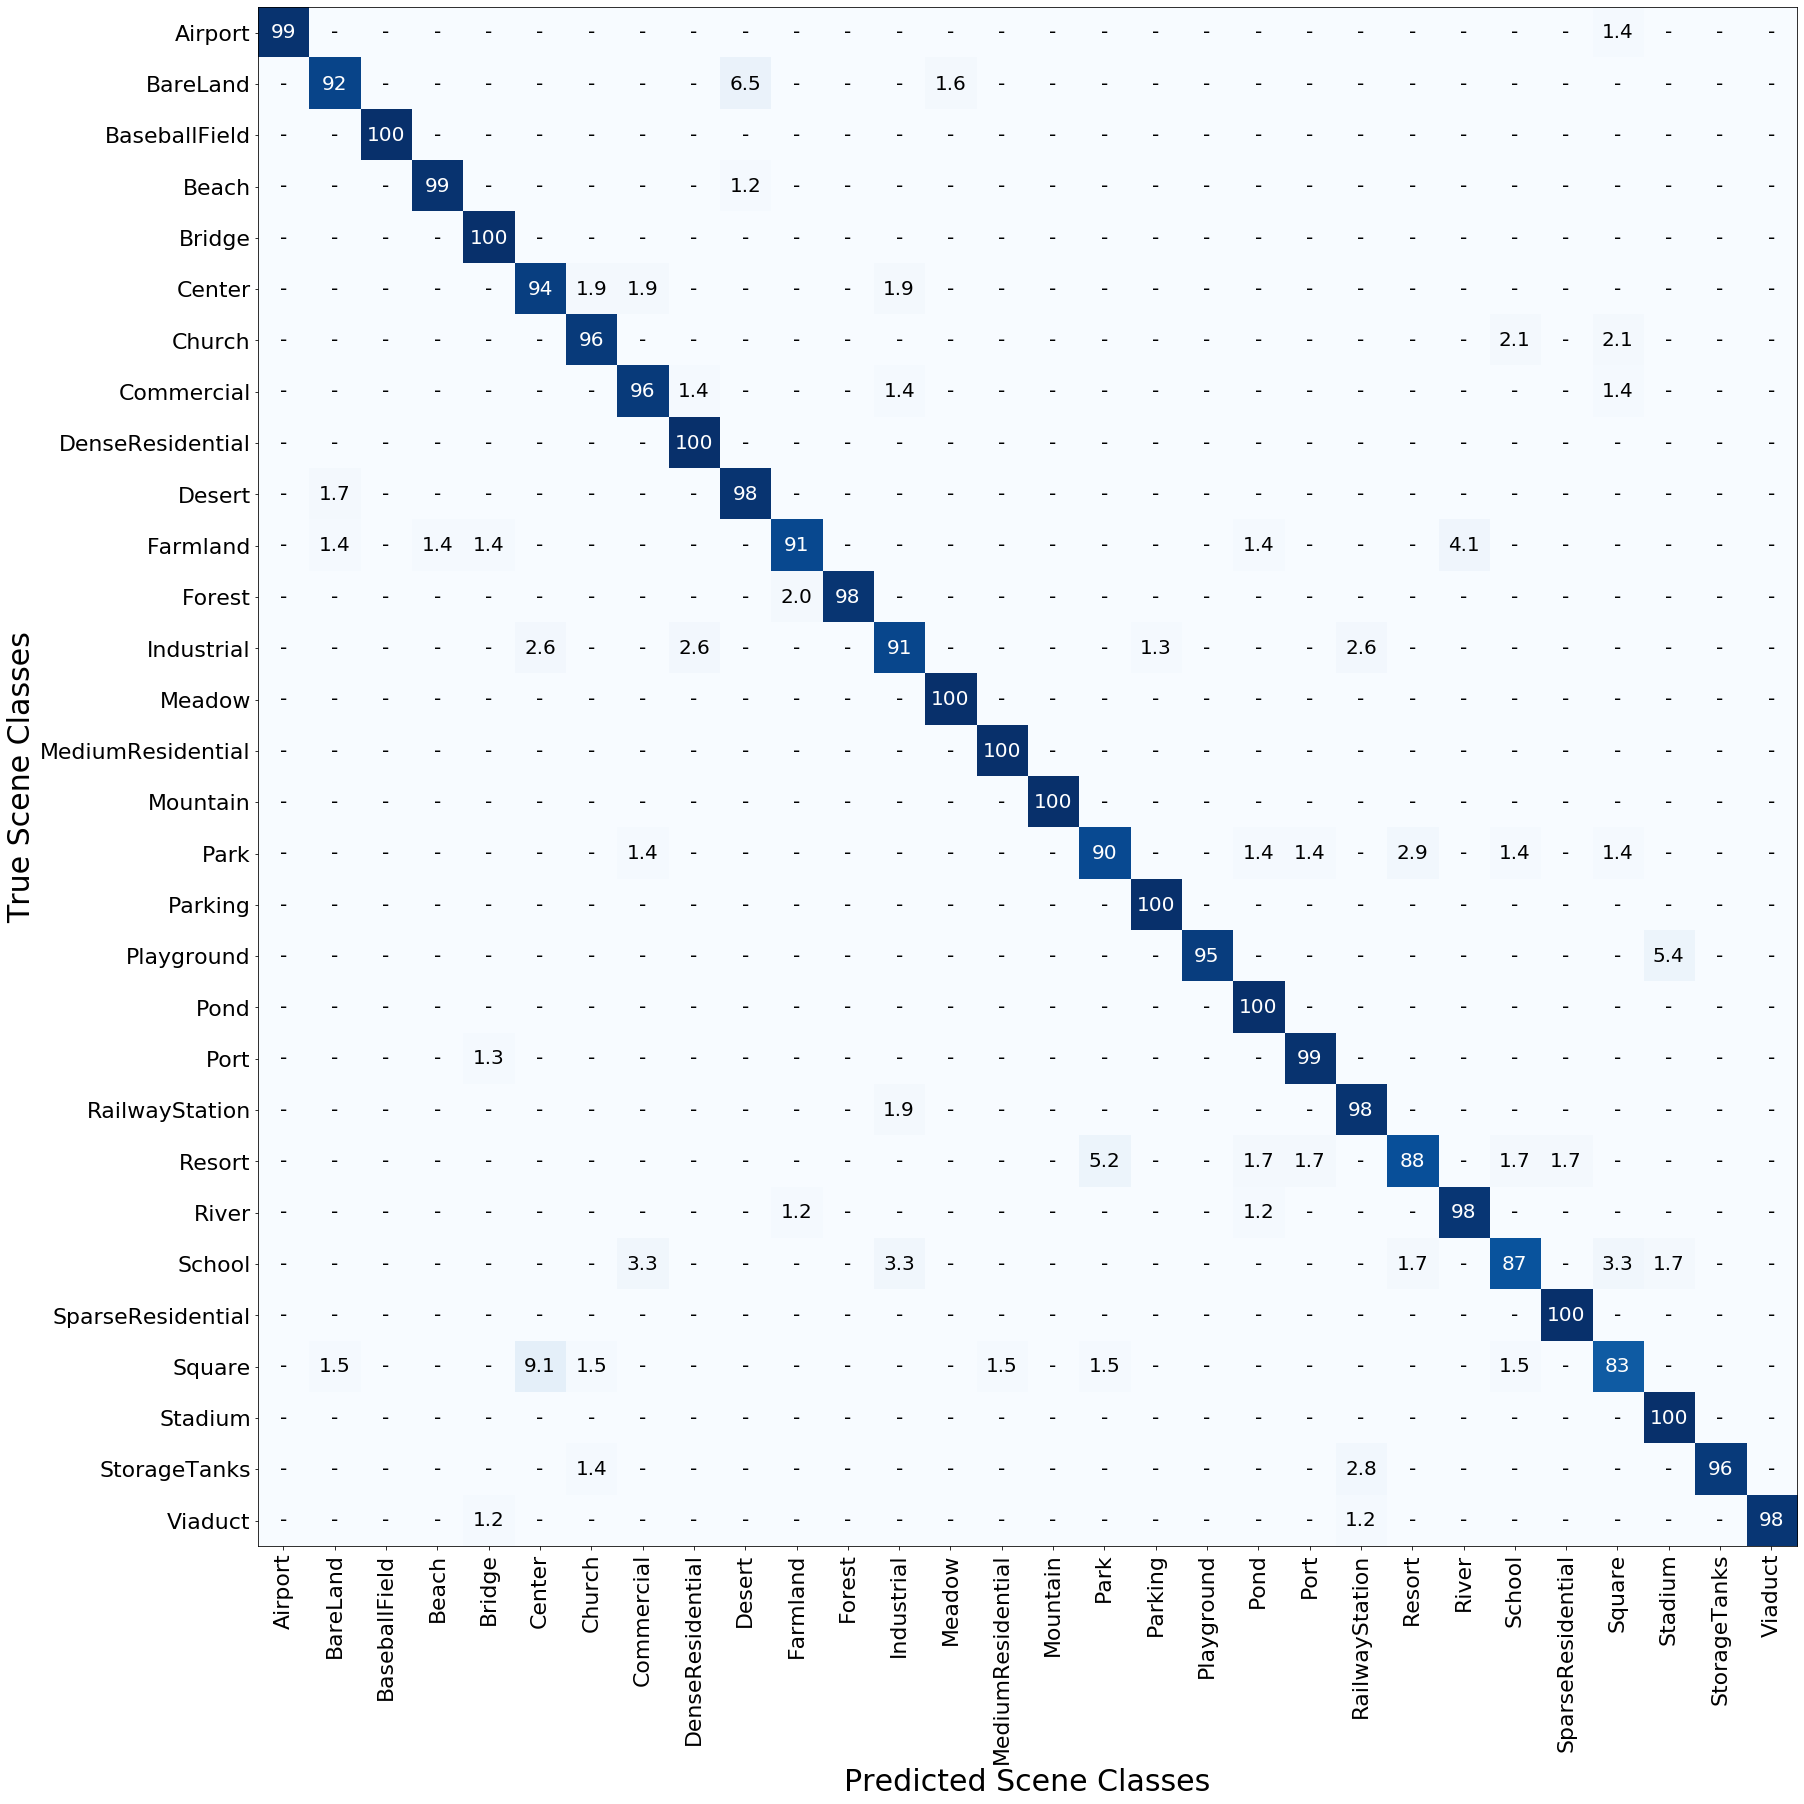

In [15]:
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22

plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "black"

plt.rcParams['font.size'] = 20
 
cm.plot_cm(normalize=True, plot_txt=True , norm_dec=0, figsize=(25, 25))

In [99]:
interp = ClassificationInterpretation.from_learner(model)
#losses,idxs = interp.top_losses()
#len(data.valid_ds)==len(losses)==len(idxs)

In [16]:
#plt.rcParams['axes.titlesize'] = 12
#cm.plot_top_losses(6, figsize=(15,15), heatmap=False)
cm.most_confused()

[('Square', 'Center', 6),
 ('BareLand', 'Desert', 4),
 ('Playground', 'Stadium', 4),
 ('Farmland', 'River', 3),
 ('Resort', 'Park', 3),
 ('Industrial', 'Center', 2),
 ('Industrial', 'DenseResidential', 2),
 ('Industrial', 'RailwayStation', 2),
 ('Park', 'Resort', 2),
 ('School', 'Commercial', 2),
 ('School', 'Industrial', 2),
 ('School', 'Square', 2),
 ('StorageTanks', 'RailwayStation', 2),
 ('Airport', 'Square', 1),
 ('BareLand', 'Meadow', 1),
 ('Beach', 'Desert', 1),
 ('Center', 'Church', 1),
 ('Center', 'Commercial', 1),
 ('Center', 'Industrial', 1),
 ('Church', 'School', 1),
 ('Church', 'Square', 1),
 ('Commercial', 'DenseResidential', 1),
 ('Commercial', 'Industrial', 1),
 ('Commercial', 'Square', 1),
 ('Desert', 'BareLand', 1),
 ('Farmland', 'BareLand', 1),
 ('Farmland', 'Beach', 1),
 ('Farmland', 'Bridge', 1),
 ('Farmland', 'Pond', 1),
 ('Forest', 'Farmland', 1),
 ('Industrial', 'Parking', 1),
 ('Park', 'Commercial', 1),
 ('Park', 'Pond', 1),
 ('Park', 'Port', 1),
 ('Park', 'Sch

In [22]:
#plt.rcParams['axes.titlesize'] = 10
#cm.plot_top_losses(9, figsize=(16,15), heatmap=False)

In [ ]:
def plot_confusion_matrix(normalize=False, cmap="Blues", slice_size=1,
                          norm_dec:int=2, plot_txt:bool=True, return_fig:bool=None, **kwargs)->Optional[plt.Figure]:
    "Plot the confusion matrix, with `title` and using `cmap`."
    # This function is mainly copied from the sklearn docs
    cm = self.confusion_matrix(slice_size=slice_size)
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(**kwargs)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(self.data.c)
    plt.xticks(tick_marks, self.data.y.classes, rotation=90)
    plt.yticks(tick_marks, self.data.y.classes, rotation=0)

    if plot_txt:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
            plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

    ax = fig.gca()
    ax.set_ylim(len(self.data.y.classes)-.5,-.5)

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.grid(False)
    if ifnone(return_fig, defaults.return_fig): return fig

In [1]:
#interp.plot_confusion_matrix(normalize=True, plot_txt=False, figsize=(25, 25), norm_dec=2)

In [39]:
# divide dataset into 80/20 for train/test respectively 
train = 700*.8
test = 700*.2
print(train, train*45, test, test*45)
25200+6300

560.0 25200.0 140.0 6300.0


31500

In [ ]:
pth = "/home/cliff/rs_imagery/NWPU-RESISC45/cm/"

In [148]:
tmf = torchvision.transforms.ToTensor()
dt = torchvision.datasets.ImageFolder(pth, tmf)
cn = dt.classes

dt_ = torch.utils.data.DataLoader(dt, 8, shuffle=True)

d, c = next(iter(dt_))
c

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

out = torchvision.utils.make_grid(d)
imshow(out, title=[cn[x] for x in c])

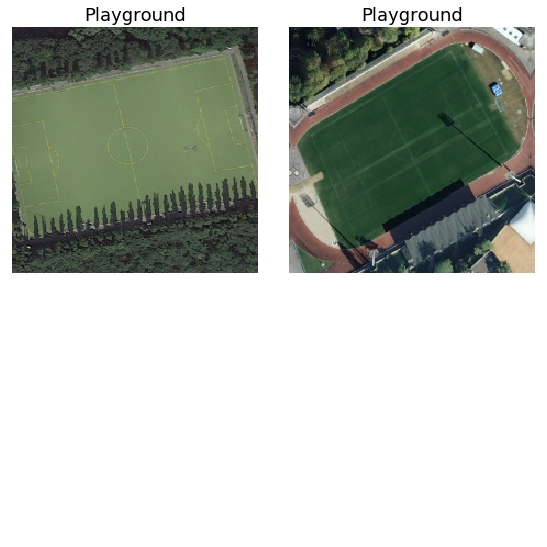

In [148]:
plt.rcParams['axes.titlesize'] = 18
tfms = get_transforms(do_flip=False)
pth = Path("/home/cliff/rs_imagery/AID")

bs = 2
data = (ImageList.from_folder(pth/'c')
        .split_by_rand_pct(valid_pct=0.1, seed=0) 
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=bs, num_workers=num_cpus())
        .normalize(cifar_stats))
data.show_batch()

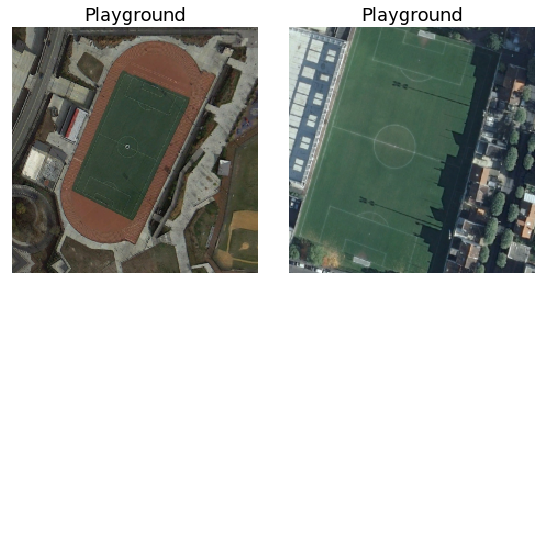

In [135]:

bs = 2
data = (ImageList.from_folder(pth/'c')
        .split_by_rand_pct(valid_pct=0.1, seed=0) 
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=bs, num_workers=num_cpus())
        .normalize(cifar_stats))
data.show_batch()

In [123]:

bs = 2
data = (ImageList.from_folder(pth/'s')
        .split_by_rand_pct(valid_pct=0.1, seed=0) 
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=bs, num_workers=num_cpus())
        .normalize(cifar_stats))
#data.show_batch()

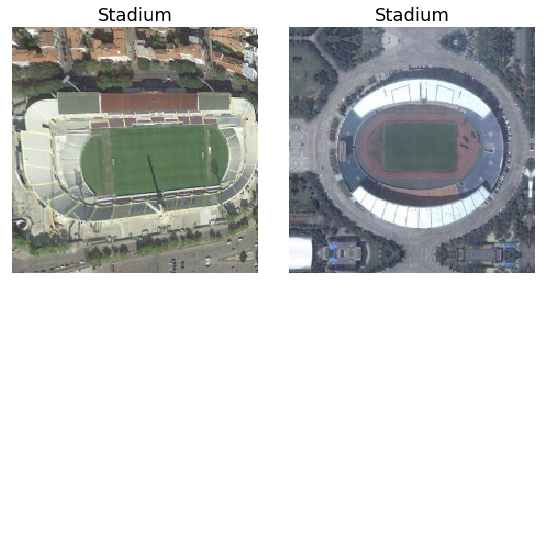

In [130]:
bs = 2
data = (ImageList.from_folder(pth/'s')
        .split_by_rand_pct(valid_pct=0.1, seed=0) 
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=bs, num_workers=num_cpus())
        .normalize(cifar_stats))
data.show_batch()

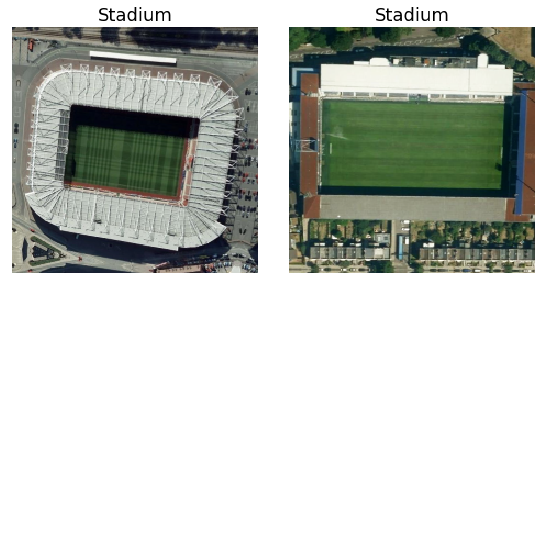

In [155]:
bs =  2
data = (ImageList.from_folder(pth/'s')
        .split_by_rand_pct(valid_pct=0.1, seed=0) 
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=bs, num_workers=num_cpus())
        .normalize(cifar_stats))

data.show_batch()

In [152]:
# bs =  2
# data = (ImageList.from_folder(pth/'p')
#         .split_by_rand_pct(valid_pct=0.1, seed=0) 
#         .label_from_folder()
#         .transform(tfms, size=224)
#         .databunch(bs=bs, num_workers=num_cpus())
#         .normalize(cifar_stats))

# data.show_batch()

In [29]:
path = Path("/home/cliff/rs_imagery/AID-50-50")
test = "/home/cliff/rs_imagery/AID-50-50/test/"
path

PosixPath('/home/cliff/rs_imagery/AID-50-50')

In [31]:
files = next(os.walk('/home/cliff/rs_imagery/AID-50-50/Airport/'))[2]
len(files)

360

In [34]:
for i in range(30):
    dest = test+str(path.ls()[0].ls()[i]).rpartition('/')[2]
    os.makedirs(dest)
    files = path.ls()[0].ls()[i].ls()
    #sample = random.sample(range(0, 700), 140)
    n_files = len(files)
    n_test = int(n_files * .5)
    sample = random.sample(range(0, n_files), n_test)
    for j in sample:
        shutil.move(str(files[j]), dest)

In [ ]:
tfms = get_transforms()

data = (ImageList.from_folder(path)
        .split_by_rand_pct(0.1)          
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=32, num_workers=num_cpus())
        .normalize())

In [ ]:
#train = Path("/home/cliff/.fastai/data/NWPU-RESISC45/train")
#images = (plt.imread(str(i)) for i in train.iterdir()) # generator comprehension
#images = np.stack(images)  # this takes time 
#np.mean(images[:,:,:,0]),np.mean(images[:,:,:,1]),np.mean(images[:,:,:,2])
#np.std(images[:,:,:,0]),np.std(images[:,:,:,1]),np.std(images[:,:,:,2])

In [41]:
import pickle

In [150]:
with open('/home/cliff/ResearchProjects/geppy_nn/mlj_experiments/4-2-train/4-2-seed-4/best/record.pkl', 
          'rb') as f:
    log = pickle.load(f)
    
for i, j in enumerate(log.select('acc')):
    print(j)

0.8061507940292358
0.8105158805847168
0.8055555820465088
0.8198412656784058
0.8101190328598022
0.8140873312950134
0.8045634627342224
0.7823412418365479
0.8178571462631226
0.8162698149681091
0.8156746029853821
0.7920634746551514
0.8061507940292358
0.8295634984970093
0.796230137348175
0.7873015999794006
0.8148809671401978
0.7950396537780762
0.800595223903656
0.8083333373069763


In [30]:
print(log)

indv                                                                                                                                                                                                                                                                                                                                                  	acc     
<class 'deap.creator.Individual'>[
	<class 'gepcore.entity.Gene'> [seq, cpi, conv3x3, conv3x3, conv1x1],
	<class 'gepcore.entity.Gene'> [seq, seq, dwconv3x3, conv3x3, conv3x3],
	<class 'gepcore.entity.Gene'> [seq, cpo, dwconv3x3, conv3x3, conv3x3],
	<class 'gepcore.entity.Gene'> [cpi, seq, conv3x3, conv3x3, conv1x1]
], linker=concat        	0.806746
<class 'deap.creator.Individual'>[
	<class 'gepcore.entity.Gene'> [seq, cpi, conv3x3, conv1x1, conv3x3],
	<class 'gepcore.entity.Gene'> [seq, cpo, conv3x3, conv1x1, conv3x3],
	<class 'gepcore.entity.Gene'> [seq, seq, dwconv3x3, conv1x1, dwconv3x3],
	<class 'gepcore.entity.Gene'> [cpo, cpo, conv3

In [139]:
with open('/home/cliff/ResearchProjects/geppy_nn/mlj_experiments/3-3-train/3-3-seed-4/acc.pkl', 
          'rb') as f:
    acc = pickle.load(f)
    
for i, j in enumerate(acc.values()):
    print(j.item())

0.8441269993782043
0.8431745767593384
0.7569841146469116
0.834761917591095
0.8365079164505005
0.8374603390693665
0.8322222232818604
0.8303174376487732
0.8449206352233887
0.8404762148857117
0.8390476107597351
0.8512698411941528
0.8214285969734192
0.8474603295326233
0.8374603390693665
0.8369840979576111
0.842380940914154
0.8512698411941528
0.8399999737739563
0.8414285778999329
